## Lectura y Limpieza

Los datos usados en este notebook estan en un google drive publico, se puede acceder al rar desde [este link](https://drive.google.com/file/d/18FPmRe_M5ajtjej-8LBExIzvyzW-wPfx/view?usp=sharing).

Descargando y extrayendo del rar debería quedar un estructura asi: `./datasets/precios/20180902/items_preciosclaros_300.csv`

In [1]:
import os
import pandas as pd
print(pd.__version__)

0.23.4


In [2]:
# Esta celda demora sus minutitos en ejecutarse
files_to_read = []
root_precios = os.path.join(".","datasets","precios")
for root, dirs, files in os.walk(root_precios):
    for fname in files:
        files_to_read.append(os.path.join(root, fname))

columnas_a_leer = ["fecha_relevamiento", "precio", "producto_id", "sucursal_id"]
precios = pd.concat((pd.read_csv(f, low_memory=False, usecols=columnas_a_leer, parse_dates=[0]) for f in files_to_read))

precios = precios[precios["precio"].notnull()]
precios["sucursal_id"] = precios["sucursal_id"].astype("category")
precios["producto_id"] = precios["producto_id"].astype("category")

# Se ejecuto en scrapper en 5 días distintos, 3 a principio de mes y 2 a final,
# para simplificar cambiamos a inicio y fin de mes.
precios["dia_relevamiento"] = precios["fecha_relevamiento"].dt.strftime('%Y-%m-%d')
precios["dia_relevamiento"] = precios["dia_relevamiento"].replace({'2018-08-31':'2018-09-01', '2018-09-02':'2018-09-01','2018-09-28':'2018-09-29'})

precios = precios.drop("fecha_relevamiento", axis="columns")

## Data Frame Comparativo para Provincia Córdoba

In [3]:
# Esto deberia ser con pivot_table pero por alguna razon se me muere la PC
df_inicio = precios[precios['dia_relevamiento'] == '2018-09-01']
df_inicio.columns = ['precio_inicio_mes', 'producto_id', 'sucursal_id', 'dia_relevamiento']
df_inicio = df_inicio.drop("dia_relevamiento", axis="columns")

df_fin = precios[precios['dia_relevamiento'] == '2018-09-29']
df_fin.columns = ['precio_fin_mes', 'producto_id', 'sucursal_id', 'dia_relevamiento']
df_fin = df_fin.drop("dia_relevamiento", axis="columns")

df_precios = df_inicio.merge(df_fin, left_on=["producto_id", "sucursal_id"], right_on=["producto_id", "sucursal_id"])
df_precios = df_precios[["producto_id", "sucursal_id", "precio_inicio_mes", "precio_fin_mes"]]
df_precios["variacion_mensual"] = round((df_precios["precio_fin_mes"] / df_precios["precio_inicio_mes"]) - 1,2)

# Filtro por quantile 0.95 para sacar outliers y cosas raras
df_precios = df_precios[df_precios.variacion_mensual < 0.33] 

#### Merge con Productos

In [4]:
productos = pd.read_csv("./datasets/productos.csv")
productos = productos.drop_duplicates() # El csv tiene muchos duplicados
df_precios = df_precios.merge(productos, left_on="producto_id", right_on="id")

df_precios["nombre"] = df_precios["nombre"].astype("category")
df_precios["marca"] = df_precios["marca"].astype("category")
df_precios["presentacion"] = df_precios["presentacion"].astype("category")
df_precios.drop("id", axis="columns", inplace=True)

#### Merge con Sucursales de Córdoba

In [5]:
sucursales = pd.read_csv("./datasets/sucursales.csv")
sucursales = sucursales[sucursales.provincia == "AR-X"]
sucursales['sucursal_id'] = sucursales.apply(lambda x: f"{x['comercioId']}-{x['banderaId']}-{x['sucursalId']}", axis=1)

cadenas = pd.read_csv('./datasets/cadenas.csv', usecols=['comercioId', 'banderaId', 'comercioRazonSocial', 'banderaDescripcion'])
cadenas.rename(dict(zip(cadenas.columns[-2:], ['empresa', 'cadena'])), inplace=True, axis="columns")
sucursales = pd.merge(sucursales, cadenas, on=['comercioId', 'banderaId'])
sucursales.drop(['provincia', 'sucursalId', 'comercioId', 'banderaId', "lat", "lng"], axis="columns", inplace=True)
sucursales.head()

df_precios = df_precios.merge(sucursales)

#### Escritura csv limpio

In [6]:
df_precios.to_csv("./datasets/analisis/cordoba_mes_de_septiembre.csv", index=False)

### Analisis

In [116]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

In [117]:
# Si queremos leer desde el csv limpio
columnas_categoricas = ['producto_id', 'sucursal_id', 'nombre', 'marca', 'presentacion', 'localidad', 'sucursalTipo', 'empresa', 'cadena']
tipo_columnas = ['category'] * len(columnas_categoricas)
col_types = dict(zip(columnas_categoricas, tipo_columnas))
df_precios = pd.read_csv("./datasets/analisis/cordoba_mes_de_septiembre.csv", low_memory=False, dtype=col_types)

In [118]:
# Sacamos outliers inferiores
df_precios = df_precios[df_precios.variacion_mensual > -0.20]

In [119]:
df_precios.variacion_mensual.describe()

count    80723.000000
mean         0.092345
std          0.095169
min         -0.190000
25%          0.000000
50%          0.100000
75%          0.160000
max          0.320000
Name: variacion_mensual, dtype: float64

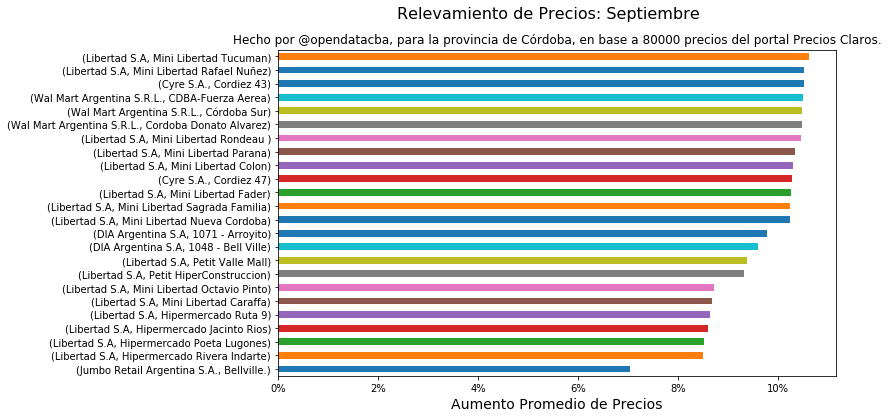

In [120]:
df_precios.groupby(["empresa","sucursalNombre"])["variacion_mensual"].mean().sort_values().plot(kind="barh")
plt.suptitle("Relevamiento de Precios: Septiembre", size=16)
plt.title("Hecho por @opendatacba, para la provincia de Córdoba, en base a 80000 precios del portal Precios Claros.")
plt.ylabel("")
plt.xlabel("Aumento Promedio de Precios", size=14)
plt.xticks([0,0.02,0.04,0.06,0.08,0.10],["0%","2%","4%", "6%", "8%", "10%"])
plt.show()

In [121]:
df_precios.groupby(["empresa","sucursalNombre"])["variacion_mensual"].mean().sort_values(ascending=False)

empresa                      sucursalNombre               
Libertad S.A                 Mini Libertad Tucuman            0.106284
                             Mini Libertad Rafael Nuñez       0.105207
Cyre S.A.                    Cordiez 43                       0.105127
Wal Mart Argentina S.R.L.    CDBA-Fuerza Aerea                0.105013
                             Córdoba Sur                      0.104782
                             Cordoba Donato Alvarez           0.104760
Libertad S.A                 Mini Libertad Rondeau            0.104688
                             Mini Libertad Parana             0.103326
                             Mini Libertad Colon              0.102915
Cyre S.A.                    Cordiez 47                       0.102721
Libertad S.A                 Mini Libertad Fader              0.102673
                             Mini Libertad Sagrada Familia    0.102462
                             Mini Libertad Nueva Cordoba      0.102435
DIA Argentina S.A 

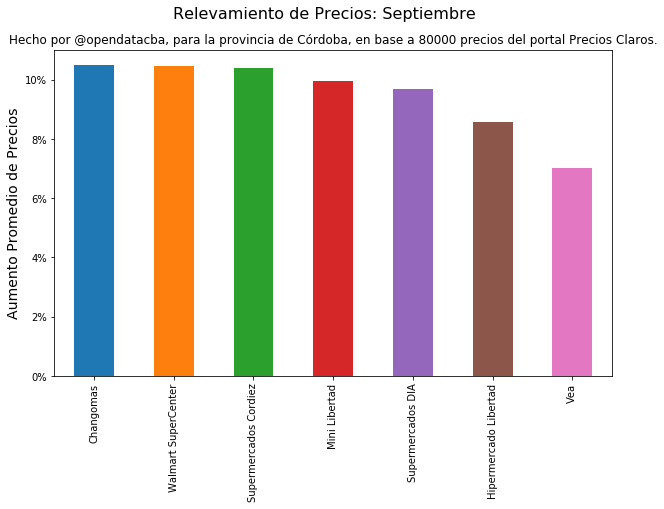

In [122]:
df_precios.groupby(["cadena"])["variacion_mensual"].mean().sort_values(ascending=False).plot(kind="bar")
plt.suptitle("Relevamiento de Precios: Septiembre", size=16)
plt.title("Hecho por @opendatacba, para la provincia de Córdoba, en base a 80000 precios del portal Precios Claros.")
plt.xlabel("")
plt.ylabel("Aumento Promedio de Precios", size=14)
plt.yticks([0,0.02,0.04,0.06,0.08,0.10],["0%","2%","4%", "6%", "8%", "10%"])
plt.show()

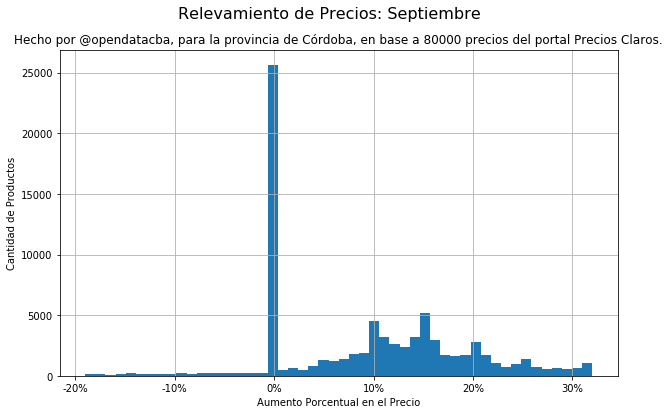

In [123]:
df_precios.variacion_mensual.hist(bins=50)
plt.suptitle("Relevamiento de Precios: Septiembre", size=16)
plt.title("Hecho por @opendatacba, para la provincia de Córdoba, en base a 80000 precios del portal Precios Claros.")
plt.ylabel("Cantidad de Productos")
plt.xlabel("Aumento Porcentual en el Precio")
plt.xticks([-0.2,-0.1,0,0.1,0.2,0.3],["-20%","-10%","0%", "10%", "20%", "30%"])
plt.show()

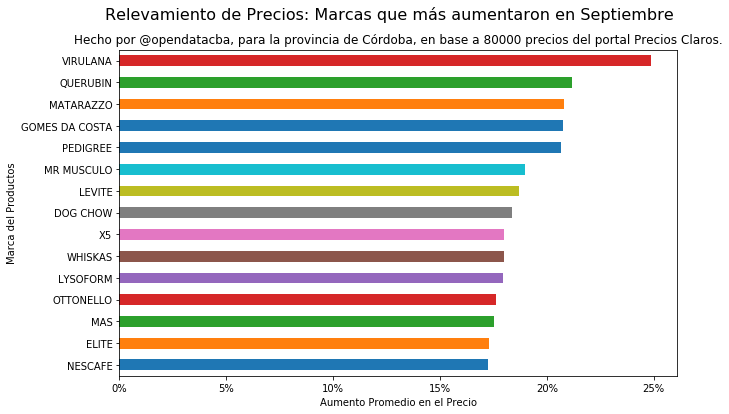

In [139]:
aumentos_marcas = df_precios.groupby("marca")["variacion_mensual"].agg({"mean", "count"}).sort_values(ascending=False, by="mean")
# Nos aseguramos que haya suficientes precios relevados como para que sea representativo el promedio
aumentos_marcas = aumentos_marcas[aumentos_marcas["count"] > 100]
aumentos_marcas.columns = ["cantidad_precios_relevados", "aumento_promedio"]

aumentos_marcas.aumento_promedio.head(15).sort_values().plot(kind="barh")
plt.suptitle("Relevamiento de Precios: Marcas que más aumentaron en Septiembre", size=16)
plt.title("Hecho por @opendatacba, para la provincia de Córdoba, en base a 80000 precios del portal Precios Claros.")
plt.ylabel("Marca del Productos")
plt.xlabel("Aumento Promedio en el Precio")
plt.xticks([0.00,0.05,0.10,0.15,0.20,0.25],["0%","5%","10%", "15%", "20%", "25%"])
plt.show()

In [47]:
df_precios[df_precios.marca == "MATARAZZO"].sort_values(by="variacion_mensual", ascending=False)

,producto_id,sucursal_id,precio_inicio_mes,precio_fin_mes,variacion_mensual,nombre,marca,presentacion,localidad,sucursalNombre,direccion,sucursalTipo,empresa,cadena
544,7790070320858,15-1-1048,38.99,51.59,0.32,Matarazzo Spaghetti Integral 500 Gr,MATARAZZO,500.0 gr,Bell Ville,1048 - Bell Ville,Cl Cordoba 602,Supermercado,DIA Argentina S.A,Supermercados DIA
2674,7790070318060,15-1-1048,38.99,51.59,0.32,Fideos Tirabuzones con 3 Vegetales Matarazzo 5...,MATARAZZO,500.0 gr,Bell Ville,1048 - Bell Ville,Cl Cordoba 602,Supermercado,DIA Argentina S.A,Supermercados DIA
54433,7790070318060,7-1-43,38.22,50.64,0.32,Fideos Tirabuzones con 3 Vegetales Matarazzo 5...,MATARAZZO,500.0 gr,CARLOS PAZ,Cordiez 43,Av. San Martin 1906,Supermercado,Cyre S.A.,Supermercados Cordiez
6042,7790070318060,15-1-1071,38.99,51.59,0.32,Fideos Tirabuzones con 3 Vegetales Matarazzo 5...,MATARAZZO,500.0 gr,Arroyito,1071 - Arroyito,Av Arturo Illia 796,Supermercado,DIA Argentina S.A,Supermercados DIA
58954,7790070318749,7-1-47,38.22,50.64,0.32,Fideos Spaghetti con Morron Matarazzo 500 Gr,MATARAZZO,500.0 gr,CAPILLA DEL MONTE,Cordiez 47,Hipolito Yrigoyen 262,Supermercado,Cyre S.A.,Supermercados Cordiez
3909,7790070320858,15-1-1071,38.99,51.59,0.32,Matarazzo Spaghetti Integral 500 Gr,MATARAZZO,500.0 gr,Arroyito,1071 - Arroyito,Av Arturo Illia 796,Supermercado,DIA Argentina S.A,Supermercados DIA
55027,7790070318749,7-1-43,38.22,50.64,0.32,Fideos Spaghetti con Morron Matarazzo 500 Gr,MATARAZZO,500.0 gr,CARLOS PAZ,Cordiez 43,Av. San Martin 1906,Supermercado,Cyre S.A.,Supermercados Cordiez
58530,7790070318077,7-1-47,38.22,50.64,0.32,Fideos Mostacholes 3 Vegetales Matarazzo 500 Gr,MATARAZZO,500.0 gr,CAPILLA DEL MONTE,Cordiez 47,Hipolito Yrigoyen 262,Supermercado,Cyre S.A.,Supermercados Cordiez
72197,7790070317476,16-2-4604,101.00,132.00,0.31,Lasagna Matarazzo 500 Gr,MATARAZZO,500.0 gr,Capital,Mini Libertad Caraffa,Av. Emilio Caraffa 2683,Autoservicio,Libertad S.A,Mini Libertad
73258,7790070317476,16-2-5104,101.00,132.00,0.31,Lasagna Matarazzo 500 Gr,MATARAZZO,500.0 gr,Capital,Mini Libertad Colon,Av. Colon 823,Autoservicio,Libertad S.A,Mini Libertad


In [8]:
df_precios[df_precios.marca == "OTTONELLO"].sort_values(by="variacion_mensual", ascending=False)

,producto_id,sucursal_id,precio_inicio_mes,precio_fin_mes,variacion_mensual,nombre,marca,presentacion,localidad,sucursalNombre,direccion,sucursalTipo,empresa,cadena
12889,7790335000082,16-1-602,28.99,36.99,0.28,Tapas Empanadas Horno Ottonello 12 Un,OTTONELLO,12.0 un,Capital,Hipermercado Ruta 9,Avda. Amadeo Sabattini 3250,Hipermercado,Libertad S.A,Hipermercado Libertad
38551,7790335000082,16-1-202,28.99,36.99,0.28,Tapas Empanadas Horno Ottonello 12 Un,OTTONELLO,12.0 un,Capital,Hipermercado Jacinto Rios,Libertad 1100,Hipermercado,Libertad S.A,Hipermercado Libertad
78357,7790335000082,16-2-4204,32.00,41.00,0.28,Tapas Empanadas Horno Ottonello 12 Un,OTTONELLO,12.0 un,Capital,Mini Libertad Sagrada Familia,Sagrada Familia 1305,Autoservicio,Libertad S.A,Mini Libertad
40469,7790335000754,16-1-202,96.99,123.99,0.28,Ravioles de Verdura Ottonello 1 Kg,OTTONELLO,1.0 kg,Capital,Hipermercado Jacinto Rios,Libertad 1100,Hipermercado,Libertad S.A,Hipermercado Libertad
78359,7790335001034,16-2-4204,32.00,41.00,0.28,Tapas Empanadas Freir Ottonello 12 Un,OTTONELLO,12.0 un,Capital,Mini Libertad Sagrada Familia,Sagrada Familia 1305,Autoservicio,Libertad S.A,Mini Libertad
40466,7790335000761,16-1-202,96.99,123.99,0.28,Ravioles de Ricotta Ottonello 1 Kg,OTTONELLO,1.0 kg,Capital,Hipermercado Jacinto Rios,Libertad 1100,Hipermercado,Libertad S.A,Hipermercado Libertad
39420,7790335000068,16-1-202,40.49,51.99,0.28,Fideos Frescos Tallarines al Huevo Ottonello 5...,OTTONELLO,500.0 gr,Capital,Hipermercado Jacinto Rios,Libertad 1100,Hipermercado,Libertad S.A,Hipermercado Libertad
38728,7790335000495,16-1-202,96.99,123.99,0.28,Ravioles de Pollo y Verdura Ottonello 1 Kg,OTTONELLO,1.0 kg,Capital,Hipermercado Jacinto Rios,Libertad 1100,Hipermercado,Libertad S.A,Hipermercado Libertad
38582,7790335001034,16-1-202,28.99,36.99,0.28,Tapas Empanadas Freir Ottonello 12 Un,OTTONELLO,12.0 un,Capital,Hipermercado Jacinto Rios,Libertad 1100,Hipermercado,Libertad S.A,Hipermercado Libertad
78492,7790335000341,16-2-4204,58.00,74.00,0.28,Ravioles de Pollo Ottonello 500 Gr,OTTONELLO,500.0 gr,Capital,Mini Libertad Sagrada Familia,Sagrada Familia 1305,Autoservicio,Libertad S.A,Mini Libertad


### Análisis Harinas

In [21]:
df_precios[df_precios.nombre.str.contains("Harina de Trigo 000")]["variacion_mensual"].describe()

count    88.000000
mean      0.102727
std       0.084346
min      -0.030000
25%       0.030000
50%       0.110000
75%       0.130000
max       0.290000
Name: variacion_mensual, dtype: float64

In [10]:
df_harinas = df_precios[df_precios.nombre.str.contains("Harina de Trigo 000")] \
    .groupby("marca", observed=True)["variacion_mensual"] \
    .agg({"mean","count"})\
    .sort_values(by="mean", ascending=False)
    
df_harinas

,count,mean
marca,,
FLORENCIA,2,0.290000
BARBARA,2,0.270000
DIA,4,0.165000
PUREZA,14,0.158571
BLANCAFLOR,19,0.118421
FAVORITA,11,0.111818
CAÑUELAS,16,0.097500
GRACIELA REAL,20,0.000000


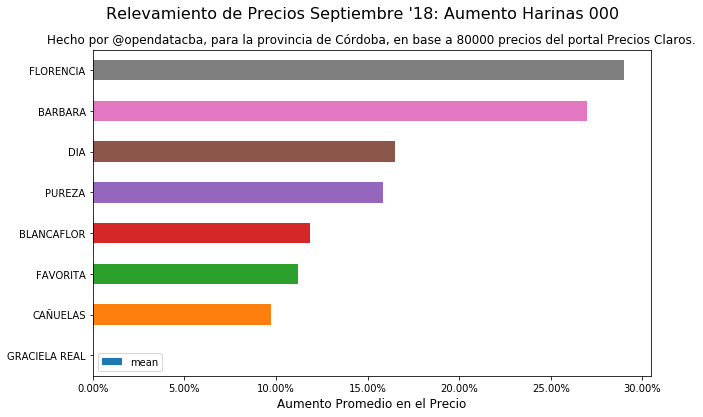

In [24]:
ax = df_harinas.sort_values(by="mean").plot(kind="barh", y="mean")
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.suptitle("Relevamiento de Precios Septiembre '18: Aumento Harinas 000", size=16)
plt.title("Hecho por @opendatacba, para la provincia de Córdoba, en base a 80000 precios del portal Precios Claros.")
plt.ylabel("")
plt.xlabel("Aumento Promedio en el Precio", size=12)
plt.show()

### Relevamiento Fideos

In [94]:
df_precios[df_precios.nombre.str.contains("Fideos")]["variacion_mensual"].describe()

count    1069.000000
mean        0.146857
std         0.095015
min        -0.190000
25%         0.110000
50%         0.160000
75%         0.200000
max         0.320000
Name: variacion_mensual, dtype: float64

In [100]:
df_fideos = df_precios[df_precios.nombre.str.contains("Fideos")] \
    .groupby("marca", observed=True)["variacion_mensual"] \
    .agg({"mean","count"})\
    .sort_values(by="mean", ascending=False)
    
df_fideos = df_fideos[df_fideos["count"] > 10]
df_fideos

,count,mean
marca,,
CICA,15,0.270000
CHICAGO,12,0.233333
VEA,14,0.228571
MATARAZZO,215,0.204837
OTTONELLO,28,0.200714
TIBALDI,14,0.190000
LA SALTEÑA,14,0.187857
LUCCHETTI,53,0.185283
MOLINOS RIO DL.PLATA,12,0.173333
